# Experiments
In this notebook we will cover some advanced configurations for Experiment. 
1. **Experiment Creation**: Creating an Experiment from scratch.
2. **Experiment Running**: Running an experiment and evaluates its learners on its environments.
5. **Experiment Multiprocessing**: Controlling execution to manage resources and optimize runtime.
6. **Experiment Restoration**: Saving results to file as an Experiment evaluates so that work isn't loss to unexpected failures.

## Experiment Creation
Before you do anything with an **Experiment** you have to create one. To create an **Experiment** we need a list of Environments and Learners:

In [7]:
from coba.environments import Environments
from coba.learners     import RandomLearner, VowpalEpsilonLearner
from coba.experiments  import Experiment

#this creates our experiment. There are more options that can be passed here. These are discussed further down.
experiment = Experiment(Environments.from_linear_synthetic(500),[VowpalEpsilonLearner(),RandomLearner()])

## Experiment Evaluation
Once an **Experiment** has been created the next step is to use it to evaluate it. This looks like this:

2022-06-08 13:50:28 -- Processing chunk...
2022-06-08 13:50:28 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-06-08 13:50:28 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-06-08 13:50:28 --   * Loading LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1)... (0.11 seconds) (completed)
2022-06-08 13:50:28 --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-06-08 13:50:28 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-06-08 13:50:28 --   * Evaluating Learner 0 on Environment 0... (0.15 seconds) (completed)
2022-06-08 13:50:28 --   * Evaluating Learner 1 on Environment 0... (0.01 seconds) (completed)


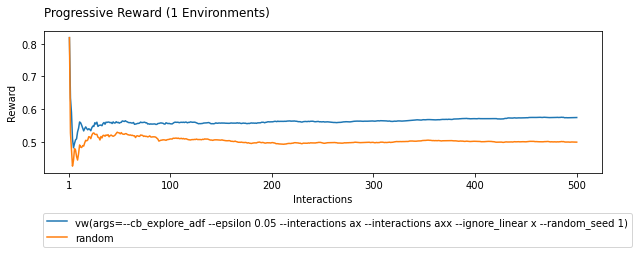

In [2]:
experiment.run().plot_learners()

## Experiment Multiprocessing

The **Experiment** class comes with highly configurable multiprocessing functionality. There are three parameters which control how **Experiment** orchestrates tasks across process:
1. `processes` Determines how many processes to use when executing an experiment.
2. `maxtasksperchild` Determines how many "tasks" processes should complete before being replaced with new processes
3. `chunk_by` Determines how tasks (i.e., environment/learner pairs) are chunked when passed to processeses for evaluation

These parameters can be set in one of three way: 
1. A coba configuration file containing the following (more information about that in the configurations notebook)
```json
{ "experiment": {"processes":1, "maxtasksperchild":0, "chunk_by":"source" } }
```
2. Programatically using the **CobaContext** interface
```python
 from coba.contexts import CobaContext

 CobaContext.experiment.processes=1
 CobaContext.experiment.maxtasksperchild= 0
 CobaContext.experiment.chunk_by = 'source'
```
3. Directly on an **Experiment**
```python
 Experiment(environments,learners).config(processes=1,chunk_by='source',maxtasksperchild=1).evaluate()
```

By default **Experiment** multiprocessing settings are `processes=1, maxtasksperchild=0, chunk_by='source'`, which means only one process will be used. Multiple processes will only be used if `processes>1` or `maxtasksperchild>0`. The `chunk_by` parameter is only relevant when multiple processes are used. Otherwise it is ignored. Below are a few examples.

2022-06-08 13:50:38 -- Processing chunk...
2022-06-08 13:50:38 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-06-08 13:50:38 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-06-08 13:50:38 --   * Loading LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1)... (0.43 seconds) (completed)
2022-06-08 13:50:38 --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-06-08 13:50:38 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-06-08 13:50:39 --   * Evaluating Learner 0 on Environment 0... (0.56 seconds) (completed)
2022-06-08 13:50:39 --   * Evaluating Learner 1 on Environment 0... (0.03 seconds) (completed)
2022-06-08 13:50:39 --   * Creating Environment 1 from Loaded Source... (0.0 seconds) (completed)
2022-06-08 13:50:39 --   * Recording Environment 1 statistics... (0.0 seconds) (completed)
2022-06-08 13:50:39 --   * Evaluating Learner 0 on Environment 1... (0.54 seconds) (completed)
2022-06-0

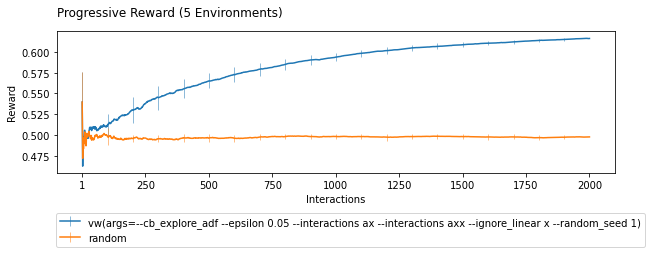

Wall time: 3.49 s


In [3]:
%%time
from coba.environments import Environments
from coba.learners     import RandomLearner, VowpalEpsilonLearner
from coba.experiments  import Experiment

environments = Environments.from_linear_synthetic(2000).shuffle([1,2,3,4,5])
learners    = [VowpalEpsilonLearner(),RandomLearner()]

#single processing, chunk_by is ignored (i.e., everything is in one chunk)
Experiment(environments, learners).run().plot_learners(err='se')

And below is an example of a Experiment that processes source chunks in parallel. Notice that when multiple processesors are executing the logging output now contains which processor sent the message in addition to when the message was sent. Also notice the difference in execution time between the single process and multiprocess runs. This example still only has one evaluation chunk because the three shuffle environments all come from the same "source".

2022-06-08 13:50:54 -- pid-8016   -- Processing chunk...
2022-06-08 13:50:54 -- pid-8016   --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-06-08 13:50:54 -- pid-8016   -- Processing chunk...
2022-06-08 13:50:54 -- pid-8016   --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-06-08 13:50:54 -- pid-8016   -- Processing chunk...
2022-06-08 13:50:55 -- pid-8016   --   * Loading LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1)... (0.45 seconds) (completed)
2022-06-08 13:50:55 -- pid-8016   --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-06-08 13:50:55 -- pid-8016   --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-06-08 13:50:55 -- pid-8016   --   * Evaluating Learner 0 on Environment 0... (0.66 seconds) (completed)
2022-06-08 13:50:55 -- pid-8016   --   * Evaluating Learner 1 on Environment 0... (0.03 seconds) (completed)
2022-06-08 13:50:55 -- pid-8016   --   * Creating Environment 1 fro

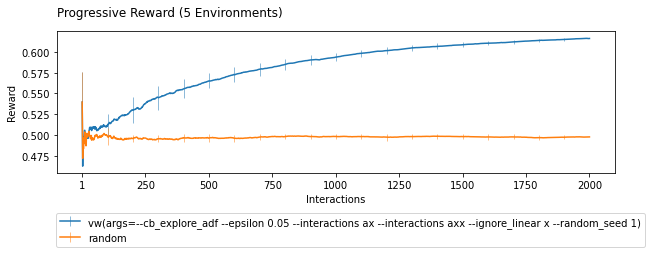

Wall time: 3.84 s


In [4]:
%%time
from coba.environments import Environments
from coba.learners     import RandomLearner, VowpalEpsilonLearner
from coba.experiments  import Experiment

environments = Environments.from_linear_synthetic(2000).shuffle([1,2,3,4,5])
learners    = [VowpalEpsilonLearner(),RandomLearner()]

#processes=2, chunk_by='source', 
#There are 10 tasks in this experiment (2 learner tasks, 3 environment tasks, 6 evaluation tasks)
#There is only 1 source, Environments.from_linear_synthetic(2000), which we filter to 3 environments
#This means there will be one chunk containing the 3 environment and 6 evaluation tasks
Experiment(environments, learners).config(processes=2, chunk_by='source').run().plot_learners(err='se')

Finally, if one wants to evaluate an Experiment in full parallel `chunk_by` can be set to `'task'`. This means each chunk will be a single task. This can drastically speed up evaluations when Learners are the processing bottleneck. Unfortunately this also means we'll end up doing some duplicate work. Notice that our environment has to be reloaded every time a task is processed.

2022-06-08 13:51:06 -- pid-19376  -- Processing chunk...
2022-06-08 13:51:06 -- pid-19376  --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-06-08 13:51:06 -- pid-19376  -- Processing chunk...
2022-06-08 13:51:06 -- pid-19376  --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-06-08 13:51:06 -- pid-19376  -- Processing chunk...
2022-06-08 13:51:06 -- pid-14576  -- Processing chunk...
2022-06-08 13:51:07 -- pid-19376  --   * Loading LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1)... (0.44 seconds) (completed)
2022-06-08 13:51:07 -- pid-19376  --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-06-08 13:51:07 -- pid-19376  --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-06-08 13:51:07 -- pid-19376  -- Processing chunk...
2022-06-08 13:51:07 -- pid-14576  --   * Loading LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1)... (0.44 seconds) (completed)
2022-06-08 13:51:07 -- pid-14576  --   * Creat

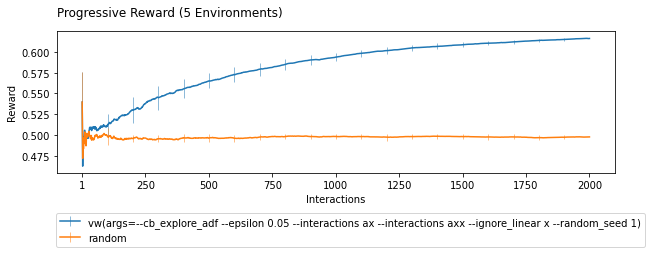

Wall time: 5.98 s


In [5]:
%%time
from coba.environments import Environments
from coba.learners     import RandomLearner, VowpalEpsilonLearner
from coba.experiments  import Experiment

environments = Environments.from_linear_synthetic(2000).shuffle([1,2,3,4,5])
learners     = [VowpalEpsilonLearner(),RandomLearner()]

#processes=2, chunk_by='task', 
#There are 10 separate tasks (2 learner tasks, 3 environment tasks, 6 evaluation tasks) 
#Each task will be chunked into its own process making 11 total chunks
Experiment(environments, learners).config(processes=2, chunk_by='task').run().plot_learners(err='se')

## Experiment Restoration

Experiments come with one final bit of functionality: if provided a file path Experiments will write their results to file as they run. This can be handy in the case of something interrupting an **Experiment** during evaluation (e.g., the internet going down or a computer being forced to restart) because the **Experiment** will be able to resume at the point of interuption. The **Experiment** restoration file is also useful for later analysis since a **Result** object can be created from it. Here's what it looks like to create a restoration/result file. Notice that if you run this code block twice the second time there will be no output due to restoration. (If you are runing this code on mybinder this may or may not work as file write permissions can be blocked)

2022-06-08 13:51:23 -- Processing chunk...
2022-06-08 13:51:23 --   * Recording Learner 0 parameters... (0.0 seconds) (completed)
2022-06-08 13:51:23 --   * Recording Learner 1 parameters... (0.0 seconds) (completed)
2022-06-08 13:51:24 --   * Loading LinearSynth(A=5,c=5,a=5,R=['a', 'xa'],seed=1)... (0.43 seconds) (completed)
2022-06-08 13:51:24 --   * Creating Environment 0 from Loaded Source... (0.0 seconds) (completed)
2022-06-08 13:51:24 --   * Recording Environment 0 statistics... (0.0 seconds) (completed)
2022-06-08 13:51:24 --   * Evaluating Learner 0 on Environment 0... (0.57 seconds) (completed)
2022-06-08 13:51:25 --   * Evaluating Learner 1 on Environment 0... (0.05 seconds) (completed)
2022-06-08 13:51:25 --   * Creating Environment 1 from Loaded Source... (0.0 seconds) (completed)
2022-06-08 13:51:25 --   * Recording Environment 1 statistics... (0.01 seconds) (completed)
2022-06-08 13:51:25 --   * Evaluating Learner 0 on Environment 1... (0.56 seconds) (completed)
2022-06-

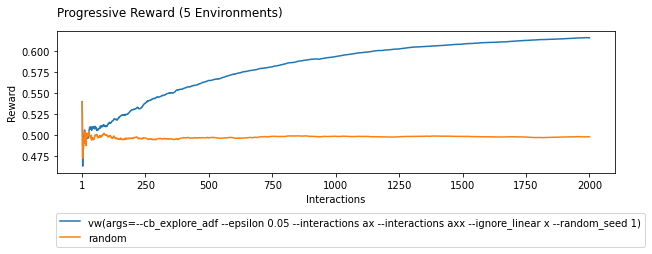

In [6]:
from coba.environments import Environments
from coba.learners     import RandomLearner, VowpalEpsilonLearner
from coba.experiments  import Experiment

environments = Environments.from_linear_synthetic(2000).shuffle([1,2,3,4,5])
learners    = [VowpalEpsilonLearner(),RandomLearner()]

Experiment(environments, learners).run('example.log').plot_learners()